# Simulation

## Prelude

In [699]:
!pip install matplotlib numpy mpmath watermark

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [700]:
%matplotlib inline

import matplotlib
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
import math
import warnings
from ipywidgets import interact, interactive, fixed, interact_manual

In [701]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = [12.0, 8.0]
plt.rcParams['text.usetex'] = False

In [702]:
import watermark.watermark as watermark
print(watermark(machine=True, iso8601=True, python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

numpy     : 1.22.2
matplotlib: 3.5.1



In [703]:
def intrange(bot, top, num = 100):
    bot = int(bot)
    top = int(top)
    x = np.linspace(bot, top, num = num)
    x = [max(min(int(x), top), bot) for x in x]
    return x

## EVM primitives

In [704]:
BASE = 2**256
SIGN = BASE // 2

In [705]:
def _valid(a):
    assert type(a) is int
    assert a >= 0
    assert a < BASE

def _abs(a):
    _valid(a)
    if a > SIGN:
        a = BASE - a
    assert a >= 0 and a < SIGN
    return a

def bnot(a):
    _valid(a)
    return a ^ (BASE - 1)

def bor(a, b):
    _valid(a)
    _valid(b)
    return a | b

def lt(a, b):
    _valid(a)
    _valid(b)
    return 1 if a < b else 0

def shl(a, b):
    _valid(a)
    _valid(b)
    return (b << a) % BASE

def shr(a, b):
    _valid(a)
    _valid(b)
    return (b >> a) % BASE

def sar(a, b):
    _valid(a)
    _valid(b)
    if b >= SIGN:
        b = BASE - b
        b >>= a
        b = BASE - max(b, 1)
        return b
    else:
        return (b >> a) % BASE

def add(a, b):
    _valid(a)
    _valid(b)
    return (a + b) % BASE

def sub(a, b):
    _valid(a)
    _valid(b)
    return (a - b) % BASE

def mul(a, b):
    _valid(a)
    _valid(b)
    return (a * b) % BASE

def div(a, b):
    _valid(a)
    _valid(b)
    return a // b

def sdiv(a, b):
    _valid(a)
    _valid(b)
    r = _abs(a) // _abs(b)
    assert r >= 0 and r < SIGN
    if r > 0 and ((a >= SIGN) ^ (b >= SIGN)):
        r = BASE - r
    assert r >= 0 and r < BASE    
    return r

def mod(a, b):
    _valid(a)
    _valid(b)
    return (a % b) % BASE

def smod(a, b):
    _valid(a)
    _valid(b)
    if b >= SIGN:
        b = BASE - b
    if a < SIGN:
        return (a % b) % BASE
    else:
        a = BASE - a
        return BASE - ((a % b) % BASE)

def mulmod(a, b, c):
    _valid(a)
    _valid(b)
    _valid(c)
    return ((a * b) % c) % BASE

## Ground truth

In [706]:
PRECISION = 1024 # Bits
mp.prec = PRECISION

In [707]:
FIX_1 = 10**18
MP_FIX_1 = mp.mpf(FIX_1)

In [708]:
def fix_to_mp(x):
    _valid(x)
    if x < 2**255:
        return mp.mpf(x) / MP_FIX_1
    else:
        x = 2**256 - x
        return -mp.mpf(x) / MP_FIX_1

In [709]:
def fix_to_f(x):
    return float(fix_to_mp(x))

In [710]:
def mp_to_fix(x):
    # Closest approximation, clamping to MIN and MAX representable values, NaN maps to positive infinite
    if mp.isnan(x):
        return SIGN - 1
    if x >= 0:
        if x >= SIGN:
            return SIGN - 1
        x = int(mp.nint(x * MP_FIX_1))
    else:
        if -x > SIGN:
            return SIGN
        x = int(mp.nint(-x * MP_FIX_1))
        if x > 0:
            x = 2**256 - x
    _valid(x)
    return x

In [711]:
def fmul(a, b):
    return bf_to_fix(fix_to_mp(a) * fix_to_mp(b))

In [712]:
def mp_log1(x):
    return mp_to_fix(mp.log(fix_to_mp(x)))

In [713]:
def mp_ln(x):
    return mp_to_fix(mp.log(fix_to_mp(x)))

In [714]:
def mp_exp(x):
    return mp_to_fix(mp.exp(fix_to_mp(x)))

In [715]:
assert fix_to_f(FIX_1) == 1.0

## Cheby generator

In [716]:
def chebyfun(f, domain, degree=11):
    start, end = domain
    start = mp.mpf(start)
    end = mp.mpf(end)
    mid = start + (end - start) / 2
    
    # To make the polynomial evaluate nicely, we center x around zero using an offset CENTER
    # Alternatively we could use Clenshaw's algorithm
    # TODO: Centering helps a lot, what about scaling?
    coeffs = mp.chebyfit(lambda x: f(x + mid), [start - mid, end - mid], degree)
    coeffs = [mp_to_fix(x) for x in coeffs]
    mid = mp_to_fix(mid)
    
    # Solidity function
    def func(x):
        nonlocal mid, coeffs
        x = sub(x, mid)
        r = coeffs[0]
        for coeff in coeffs[1:]:
            # r = (r * x / 1e18) + coeff
            r = mul(r, x)
            r = sdiv(r, FIX_1)
            r = add(r, coeff)
        return r
    
    # Plot error
    x = intrange(mp_to_fix(start), mp_to_fix(end), num = 10000)
    xr = np.array([fix_to_f(x) for x in x])
    y = np.array([mp_to_fix(f(fix_to_mp(x))) for x in x], dtype='object')
    yr = np.array([fix_to_f(y) for y in y])
    fy = np.array([func(x) for x in x], dtype='object')
    fyr = np.array([fix_to_f(y) for y in fy])
    plt.title('Error over domain')
    plt.xlabel("$x$")
    plt.ylabel("$f(x) - r$")
    plt.plot(xr, (fyr - yr).astype(float))
    plt.axhline(-0.5 / FIX_1, color='red')
    plt.axhline(+0.5 / FIX_1, color='red')
    error_fix = max(abs(fy - y))
    error_bits = max(np.log2(abs(fy - y).astype(float)))
    
    # Print Solidity
    print('// Chebyshev approximation on ({:.4g}, {:.4g}) deg {}.'.format(float(start), float(end), degree))
    print('// Max observed error {:.2g}, last {:.2g} bits.'.format(fix_to_f(error_fix), error_bits))
    if mid < SIGN:
        print('x -= 0x{:x}; // {:.3g}'.format(mid, fix_to_f(mid)))
    else:
        print('x += 0x{:x}; // {:.3g}'.format(BASE - mid, fix_to_f(mid)))
    if coeffs[0] < SIGN:
        print('int256 r = 0x{:x}; // {:.3g}'.format(coeffs[0], fix_to_f(coeffs[0])))
    else:
        print('int256 r = -0x{:x}; // {:.3g}'.format(BASE - coeffs[0], fix_to_f(coeffs[0])))
    for x in coeffs:
        if x < SIGN:
            print('r = ((r * x) / FIX_1) + 0x{:x}; // {:.3g}'.format(x, fix_to_f(x)))
        else:
            print('r = ((r * x) / FIX_1) - 0x{:x}; // {:.3g}'.format(BASE - x, fix_to_f(x)))

    return func

In [717]:
def fn_exp(x):
    return mp.exp(x)

In [718]:
domain = (0.0, 0.125)

In [719]:
interact(lambda d:chebyfun(fn_exp, domain, degree=d), d=8)

interactive(children=(IntSlider(value=8, description='d', max=24, min=-8), Output()), _dom_classes=('widget-in…

<function __main__.<lambda>(d)>

In [720]:
fix_to_mp(FIX_1)

mpf('1.0')

In [721]:
sdiv(115792089237316195423570985008687907853269484665640564039457584007913129639936, FIX_1)

115792089237316195423570985008687907853269984665640564039457084007913129639936

// Chebyshev approximation on (0, 0.125) deg 11.
// Max observed error 1e-18, last 0 bits.
x -= 0xde0b6b3a764000; // 0.0625
int256 r = 0x444e371820; // 2.93e-07
r = ((r * x) / FIX_1) + 0x444e371820; // 2.93e-07
r = ((r * x) / FIX_1) + 0x2ab10ff87b6; // 2.93e-06
r = ((r * x) / FIX_1) + 0x1802ff4bd772; // 2.64e-05
r = ((r * x) / FIX_1) + 0xc017fa590a66; // 0.000211
r = ((r * x) / FIX_1) + 0x540a7d8e6d194; // 0.00148
r = ((r * x) / FIX_1) + 0x1f83ef1568ed35; // 0.00887
r = ((r * x) / FIX_1) + 0x9d93ab6b0c7caf; // 0.0444
r = ((r * x) / FIX_1) + 0x2764eadac31f2ba; // 0.177
r = ((r * x) / FIX_1) + 0x762ec090495d833; // 0.532
r = ((r * x) / FIX_1) + 0xec5d812092bb066; // 1.06
r = ((r * x) / FIX_1) + 0xec5d812092bb066; // 1.06


/var/folders/cb/n6k1dpbn7f1_n5m5dqv6rjvc0000gn/T/ipykernel_85508/2621324204.py:40: RuntimeWarning: divide by zero encountered in log2
  error_bits = max(np.log2(abs(fy - y).astype(float)))


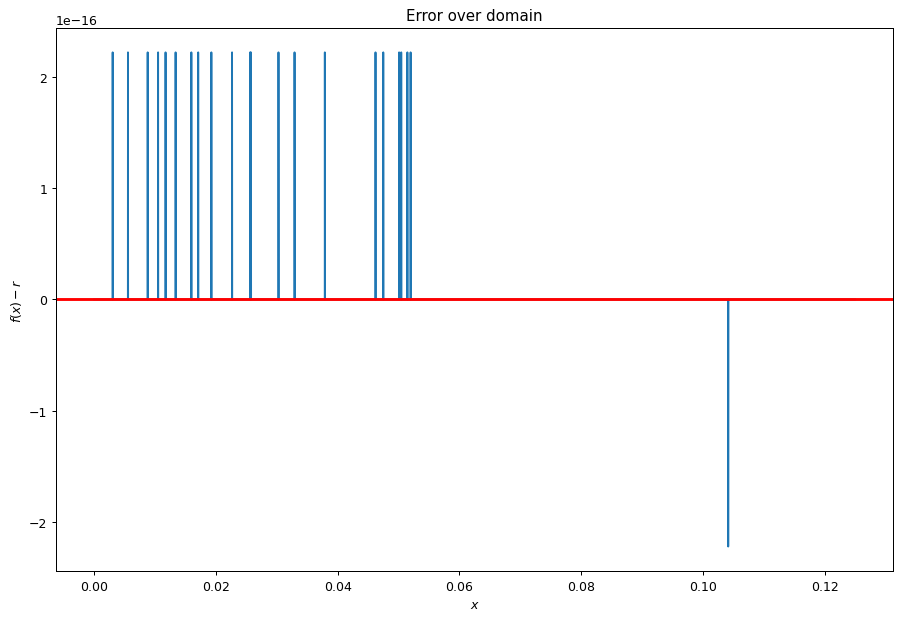

In [722]:
my_log1 = chebyfun(fn_exp, domain, degree=11)

// Chebyshev approximation on (0, 0.125) deg 17.
// Max observed error 1e-18, last 0 bits.
x -= 0xde0b6b3a764000; // 0.0625
int256 r = 0xc6c0; // 5.09e-14
r = ((r * x) / FIX_1) + 0xc6c0; // 5.09e-14
r = ((r * x) / FIX_1) + 0xc6c06; // 8.14e-13
r = ((r * x) / FIX_1) + 0xba5171; // 1.22e-11
r = ((r * x) / FIX_1) + 0xa30742f; // 1.71e-10
r = ((r * x) / FIX_1) + 0x8475e66d; // 2.22e-09
r = ((r * x) / FIX_1) + 0x63586cd21; // 2.67e-08
r = ((r * x) / FIX_1) + 0x444ccad066; // 2.93e-07
r = ((r * x) / FIX_1) + 0x2aaffec23f8; // 2.93e-06
r = ((r * x) / FIX_1) + 0x1802ff4d43bb; // 2.64e-05
r = ((r * x) / FIX_1) + 0xc017fa6a1dda; // 0.000211
r = ((r * x) / FIX_1) + 0x540a7d8e6d0f5; // 0.00148
r = ((r * x) / FIX_1) + 0x1f83ef1568e5bd; // 0.00887
r = ((r * x) / FIX_1) + 0x9d93ab6b0c7caf; // 0.0444
r = ((r * x) / FIX_1) + 0x2764eadac31f2bc; // 0.177
r = ((r * x) / FIX_1) + 0x762ec090495d833; // 0.532
r = ((r * x) / FIX_1) + 0xec5d812092bb066; // 1.06
r = ((r * x) / FIX_1) + 0xec5d812092bb066; // 1.0

/var/folders/cb/n6k1dpbn7f1_n5m5dqv6rjvc0000gn/T/ipykernel_85508/2621324204.py:40: RuntimeWarning: divide by zero encountered in log2
  error_bits = max(np.log2(abs(fy - y).astype(float)))


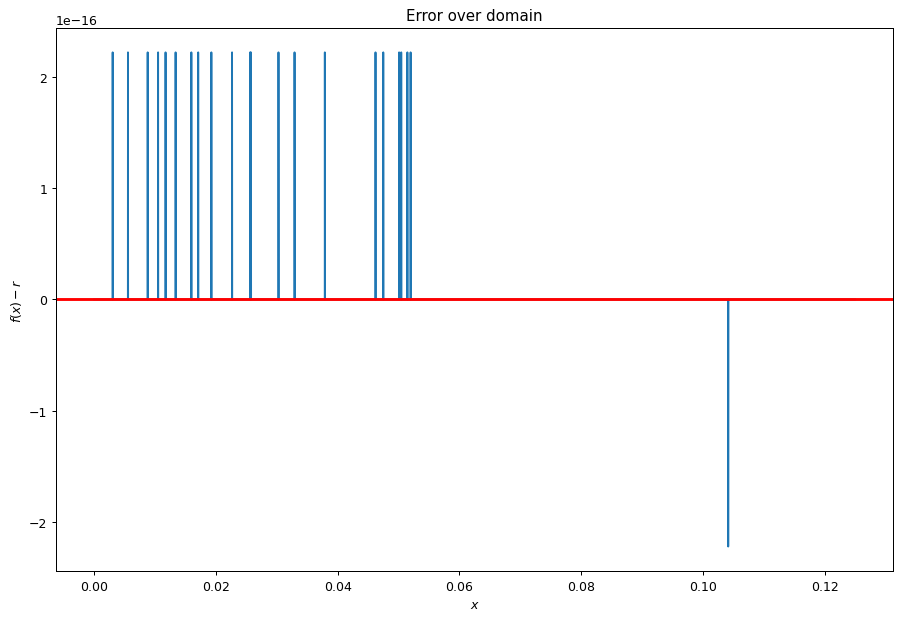

In [723]:
my_exp = chebyfun(mp.exp, (0.0, 0.125), degree=17)

In [724]:
def chebyshev_nodes(domain, n):
    start, end = domain
    start = mp.mpf(start)
    end = mp.mpf(end)
    mid = (start + end) / 2
    amp = (end - start) / 2
    xs = []
    for i in range(n):
        f = mp.mpf(2 * i + 1) / mp.mpf(2 * n)
        xs += [mid - amp * mp.cos(mp.pi * f)]
    return xs

In [725]:
def least_squares(A, b):
    U, S, V = mp.svd_r(A)
    for i in range(len(S)):
        if S[i] != 0:
            S[i] = mp.one / S[i]
    return V.T * mp.diag(S) * U.T * b

In [726]:
def vandermonde(x, n):
    A = mp.matrix(len(x), n)
    for i, x in enumerate(x):
        r = mp.one
        for j in range(n):
            A[i, j] = r
            r *= x
    return A

In [727]:
f = lambda x: mp.exp(x + 0.0625)
d = (0.0 - 0.0625, 0.125 - 0.0625)
x = chebyshev_nodes(d, 17)
y = mp.matrix([f(x) for x in x])
c = least_squares(vandermonde(x, 17), y)
[hex(mp_to_fix(c)) for c in c]

['0xec5d812092bb066',
 '0xec5d812092bb066',
 '0x762ec090495d833',
 '0x2764eadac31f2bc',
 '0x9d93ab6b0c7caf',
 '0x1f83ef1568e5bd',
 '0x540a7d8e6d0f5',
 '0xc017fa6a1dda',
 '0x1802ff4d43bb',
 '0x2aaffec23f8',
 '0x444ccad066',
 '0x63586cd21',
 '0x8475e66d',
 '0xa30742f',
 '0xba5171',
 '0xc6c06',
 '0xc6c0']

In [728]:
def extrema(domain, f, c, derivative=None):
    # If no derivative of f is provided, produce one numerically
    if derivative is None:
        derivative = lambda x: mp.diff(f, x)
    
    # Create a derivative of the polynomial
    c = reversed([c for i, c in enumerate(c[0:-1:-1])])
    
    # Find extrema in the domain
    f = lambda x: polyval(c, x) - derivative(x)
    

In [729]:
def remez(x, n):
    A = mp.matrix(len(x), n + 1)
    for i, x in enumerate(x):
        r = mp.one
        for j in range(n):
            A[i, j] = r
            r *= x
        A[i, n] = mp.one if i % 2 == 0 else -mp.one
    return A

In [730]:
c = least_squares(remez(x, 17), y)
print(c)
[hex(mp_to_fix(c)) for c in c]

[                                        1.064494458917859429563390594642889673102196875845794886517105937190162527623104184288352002087062444916185097998146973676999146529590008869969558781261740862644423323725219259737153328509480186422719447146723913658882839342929673106434827099147177303050246944554417728929839725312684720785776136017026261039]
[                                        1.064494458917859429563390594642889673058638708206661182621077187627694944548695685861988047180905087922655644777457560275773875519471511126695473462269441402302811719248095048074577457344620877539438423036294088876980319546748464921955284949935366206750043877210754826871189247789411550281646876626372126051]
[                                       0.5322472294589297147816952973214447861877371852109614158614529618145239852511230477816272801728021393842138151567391157349025865086517863474588381859957546764036157429393020264486787014960261009671326603765063351888450741892558684401618698421040369310270487

['0xec5d812092bb066',
 '0xec5d812092bb066',
 '0x762ec090495d833',
 '0x2764eadac31f2bc',
 '0x9d93ab6b0c7caf',
 '0x1f83ef1568e5bd',
 '0x540a7d8e6d0f5',
 '0xc017fa6a1dda',
 '0x1802ff4d43bb',
 '0x2aaffec23f8',
 '0x444ccad066',
 '0x63586cd21',
 '0x8475e66d',
 '0xa30742f',
 '0xba5160',
 '0xc6c06',
 '0xcb2e',
 '0x0']

## LibFixMath

**TODO.** LibFixedMath uses signed int, not unsigned

In [ ]:
FIXED_1 = 0x0000000000000000000000000000000080000000000000000000000000000000
MANTISA_MASK = 0x7fffffffffffffffffffffffffffffff
LN_MIN_VAL = 0x0000000000000000000000000000000000000000000000000000000733048c5a
LN_MAX_VAL = FIXED_1
EXP_MIN_VAL = BASE - 0x0000000000000000000000000000001ff0000000000000000000000000000000

In [ ]:
def lib_toInteger(x):
    return div(x, FIXED_1)

In [ ]:
def lib_toMantissa(x):
    if x > 0:
        return x & MANTISSA_MASK

In [ ]:
def lib_mul(a, b):
    aI = lib_toInteger(a)
    aM = lib_toMantissa(a)
    aI = lib_toInteger(b)
    aM = lib_toMantissa(b)
    
    integerPart = mul(FIXED_1, mul(aI, bI))

In [ ]:
def lib_log1(x):
    # Valid over range ~0.87 - 1.0
    r = 0
    y = sub(x, FIXED_1)
    z = y
    w = sdiv(mul(y, y), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x100000000000000000000000000000000, y)), 0x100000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x0aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa, y)), 0x200000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x099999999999999999999999999999999, y)), 0x300000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x092492492492492492492492492492492, y)), 0x400000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x08e38e38e38e38e38e38e38e38e38e38e, y)), 0x500000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x08ba2e8ba2e8ba2e8ba2e8ba2e8ba2e8b, y)), 0x600000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x089d89d89d89d89d89d89d89d89d89d89, y)), 0x700000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x088888888888888888888888888888888, y)), 0x800000000000000000000000000000000))
    return r

In [ ]:
t = []
def lib_ln(x, reductions='old', log='old'):
    global t
    _valid(x)
    if x > LN_MAX_VAL:
        raise "ln: value too large"
    if x == 0 or x >= SIGN:
        raise "ln: value too small"
    if x == FIXED_1:
        return 0
    if x <= LN_MIN_VAL:
        return EXP_MIN_VAL
    
    r = 0
    y = 0
    z = 0
    w = 0
    
    old_values = [
        0x00000000000000000000000000000000000000000001c8464f76164760000000,
        0x00000000000000000000000000000000000000f1aaddd7742e90000000000000,
        0x00000000000000000000000000000000000afe10820813d78000000000000000,
        0x0000000000000000000000000000000002582ab704279ec00000000000000000,
        0x000000000000000000000000000000001152aaa3bf81cc000000000000000000,
        0x000000000000000000000000000000002f16ac6c59de70000000000000000000,
        0x000000000000000000000000000000004da2cbf1be5828000000000000000000,
        0x0000000000000000000000000000000063afbe7ab2082c000000000000000000,
        0x0000000000000000000000000000000070f5a893b608861e1f58934f97aea57d,
    ]
    new_values = [
        0x1c8464f76164681e299a0,
        0xf1aaddd7742e56d32fb9f99744,
        0xafe10820813d65dfe6a33c07f738f,
        0x2582ab704279e8efd15e0265855c47b,
        0x1152aaa3bf81cb9fdb76eae12d029572,
        0x2f16ac6c59de6f8d5d6f63c1482a7c87,
        0x4da2cbf1be5827f9eb3ad1aa9866ebb4,
        0x63afbe7ab2082ba1a0ae5e4eb1b479dd,
        0x70f5a893b608861e1f58934f97aea57d,
    ]
    reduction_values = old_values if reductions == 'old' else new_values
    for i, v in enumerate(reduction_values):
        if x <= v:
            r = sub(r, 0x0000000000000000000000000000001000000000000000000000000000000000 >> i)
            x = sdiv(mul(x, FIXED_1), v)
    
    t += [x]
    if log == 'new':
        return add(r, my_log1(x))
    
    y = sub(x, FIXED_1)
    z = y
    w = sdiv(mul(y, y), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x100000000000000000000000000000000, y)), 0x100000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x0aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa, y)), 0x200000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x099999999999999999999999999999999, y)), 0x300000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x092492492492492492492492492492492, y)), 0x400000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x08e38e38e38e38e38e38e38e38e38e38e, y)), 0x500000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x08ba2e8ba2e8ba2e8ba2e8ba2e8ba2e8b, y)), 0x600000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x089d89d89d89d89d89d89d89d89d89d89, y)), 0x700000000000000000000000000000000))
    z = sdiv(mul(z, w), FIXED_1)
    r = add(r, sdiv(mul(z, sub(0x088888888888888888888888888888888, y)), 0x800000000000000000000000000000000))
    
    return r

In [ ]:
for i in range(-3,6):
    print(2**i)
    print(hex( mp_to_fix( mp.exp(-mp.mpf(2) ** (i)) )))

In [ ]:
def my_mul(a, b):
    mm = mulmod(a, b, bnot(0))
    r0 = mul(a, b)
    r1 = sub(sub(mm, r0), lt(mm, r0))
    r1 = add(r1, mul(sar(256, a), b))
    r1 = add(r1, mul(sar(256, b), a))
    r = bor(shl(129, r1), shr(127, r0))
    return r

In [ ]:
a = 2617556668622594272776707985386330127
b = BASE - 130444458470968929913751441309200329514

In [ ]:
fix_to_f(a)

In [ ]:
fix_to_f(b)

In [ ]:
d = my_mul(a, b)
d

In [ ]:
fix_to_f(d)

In [ ]:
0.01538461538461533 * -0.7666836201434823

In [ ]:
hex(sar(256, mp_to_fix(-2)))

# Evaluate

In [ ]:
x = intrange(mp_to_fix(0.875), mp_to_fix(1.0), num = 10000)
xr = [fix_to_f(x) for x in x]

In [ ]:
def fix_exp(x):
    return x.pow(1/(1-x))

In [ ]:
y = np.array([fix_exp(x) for x in x])
yr = np.array([fix_to_f(y) for y in y])

### Log(1 + z)

In [ ]:
x = intrange(mp_to_fix(0.875), mp_to_fix(1.0), num = 10000)
xr = [fix_to_f(x) for x in x]

In [ ]:
y = np.array([mp_log1(x) for x in x])
yr = np.array([fix_to_f(y) for y in y])

In [ ]:
ly = np.array([lib_log1(x) for x in x])
lyr = np.array([fix_to_f(y) for y in ly])

In [ ]:
my = np.array([my_log1(x) for x in x])
myr = np.array([fix_to_f(y) for y in my])

In [ ]:
plt.plot(xr, yr)
plt.plot(xr, lyr)
plt.plot(xr, myr)

In [ ]:
plt.plot(xr, np.log2(abs(ly - y).astype(float)))
plt.plot(xr, np.log2(abs(my - y).astype(float)))

### Exp(x)

In [ ]:
x = intrange(mp_to_fix(0.0), mp_to_fix(0.125), num = 10000)
xr = [fix_to_f(x) for x in x]

In [ ]:
y = np.array([mp_exp(x) for x in x])
yr = np.array([fix_to_f(y) for y in y])

In [ ]:
my = np.array([my_exp(x) for x in x])
myr = np.array([fix_to_f(y) for y in my])

In [ ]:
plt.plot(xr, yr)
plt.plot(xr, myr)

In [ ]:
plt.plot(xr, np.log2(abs(my - y).astype(float)))

### Ln(x)

In [ ]:
t = []

In [ ]:
x = intrange(LN_MIN_VAL, LN_MAX_VAL, num = 10000)
xr = [fix_to_f(x) for x in x]

In [ ]:
y = np.array([mp_ln(x) for x in x])
yr = np.array([fix_to_f(y) for y in y])

In [ ]:
ly = np.array([lib_ln(x) for x in x])
lyr = np.array([fix_to_f(y) for y in ly])

In [ ]:
lz = np.array([lib_ln(x, reductions='new', log='new') for x in x])
lzr = np.array([fix_to_f(z) for z in lz])

In [ ]:
plt.plot(xr, yr)
plt.plot(xr, lyr)
plt.plot(xr, lzr)

In [ ]:
plt.plot(xr, np.log2(abs(ly - y).astype(float)))
plt.plot(xr, np.log2(abs(lz - y).astype(float)))

In [ ]:
(fix_to_f(min(t)), fix_to_f(max(t)))

In [ ]:
plt.plot([fix_to_f(t) for t in t])